<a href="https://colab.research.google.com/github/sibot89/PyTorch/blob/main/Binary_Prediction_of_Poisnous_Mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!mkdir /content/data

In [5]:
!cp /content/drive/MyDrive/data/playground-series-s4e8.zip /content/data/

In [6]:
!unzip /content/data/playground-series-s4e8.zip -d /content/data

Archive:  /content/data/playground-series-s4e8.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [7]:
!rm /content/data/playground-series-s4e8.zip

In [8]:
df_train = pd.read_csv('/content/data/train.csv')
df_train

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,3116941,e,10.88,s,NaN,w,t,d,c,p,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,3116942,p,7.82,x,e,e,f,a,NaN,w,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,3116943,e,9.45,p,i,n,t,e,NaN,p,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


In [9]:
df_train = df_train.drop(['id'], axis=1)
df_train.shape

(3116945, 21)

In [10]:
num_samples, num_features = df_train.shape
num_features -= 1
num_classes = len(np.unique(df_train['class']))
num_samples, num_features, num_classes

(3116945, 20, 2)

In [11]:
df_train, df_valid = train_test_split(df_train, train_size=0.8,
                                                    random_state=42, shuffle=True, stratify=df_train['class'])


Dealing with missin values

In [12]:
df_train.isna().mean() * 100

,0
class,0.000000
cap-diameter,0.000160
cap-shape,0.001283
cap-surface,21.524000
cap-color,0.000401
does-bruise-or-bleed,0.000241
gill-attachment,16.807603
gill-spacing,40.373467
gill-color,0.001724
stem-height,0.000000


In [13]:
missing_threshold = 0.95

high_missing_threshold = df_train.columns[df_train.isna().mean() >
                                          missing_threshold]

df_train = df_train.drop(columns=high_missing_threshold)
df_valid = df_valid.drop(columns=high_missing_threshold)

In [14]:
mode_values = df_train.mode()
mode_values = mode_values.loc[0].to_dict()

mode_values

{'class': 'p',
 'cap-diameter': 1.49,
 'cap-shape': 'x',
 'cap-surface': 't',
 'cap-color': 'n',
 'does-bruise-or-bleed': 'f',
 'gill-attachment': 'a',
 'gill-spacing': 'c',
 'gill-color': 'w',
 'stem-height': 5.24,
 'stem-width': 2.41,
 'stem-root': 'b',
 'stem-surface': 's',
 'stem-color': 'w',
 'veil-type': 'u',
 'veil-color': 'w',
 'has-ring': 'f',
 'ring-type': 'f',
 'spore-print-color': 'k',
 'habitat': 'd',
 'season': 'a'}

In [15]:
median_values = df_train.median(numeric_only=True).to_dict()
median_values

{'cap-diameter': 5.75, 'stem-height': 5.88, 'stem-width': 9.65}

In [16]:
for column in df_train.columns:
  if df_train[column].isna().any():

    if df_train[column].dtype == 'object':
      df_train[column] = df_train[column].fillna(mode_values[column])
      df_valid[column] = df_valid[column].fillna(mode_values[column])

    else:
      df_train[column] = df_train[column].fillna(median_values[column])
      df_valid[column] = df_valid[column].fillna(median_values[column])

df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
586767,p,4.95,x,t,p,f,a,c,w,3.80,...,b,s,y,u,w,f,f,k,d,a
2665706,p,1.47,b,y,n,f,a,c,k,5.23,...,b,s,w,u,w,f,f,k,d,u
1270574,e,10.29,x,e,l,f,x,c,w,7.17,...,b,s,w,u,w,f,f,k,d,a
2935630,p,7.45,s,d,n,t,d,c,n,6.20,...,b,s,e,u,w,f,f,k,d,a
3113991,p,5.44,x,t,e,f,a,c,r,3.23,...,b,s,y,u,w,f,f,k,d,a


In [17]:
df_train.isna().sum()

,0
class,0
cap-diameter,0
cap-shape,0
cap-surface,0
cap-color,0
does-bruise-or-bleed,0
gill-attachment,0
gill-spacing,0
gill-color,0
stem-height,0


Encoding

In [18]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [19]:
cat_cols_train = df_train.select_dtypes(include='object').columns
cat_cols_train

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [20]:
df_train[cat_cols_train] = ordinal_encoder.fit_transform(df_train[cat_cols_train].astype(str))
df_valid[cat_cols_train] = ordinal_encoder.transform(df_valid[cat_cols_train].astype(str))

In [21]:
X_train = df_train.drop(['class'], axis=1).values
y_train = df_train['class'].values.reshape(-1, 1)

X_valid = df_valid.drop(['class'], axis=1).values
y_valid = df_valid['class'].values.reshape(-1, 1)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2493556, 20), (2493556, 1), (623389, 20), (623389, 1))

In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([2493556, 20]),
 torch.Size([2493556, 1]),
 torch.Size([623389, 20]),
 torch.Size([623389, 1]))

In [23]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)

In [24]:
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512)

In [25]:
nfl1 = 2 * num_features

model = nn.Sequential(
    nn.Linear(num_features, nfl1),
    nn.ReLU(),
    nn.Linear(nfl1, 1),
    nn.Sigmoid()
)
model.to(device)

Sequential(
  (0): Linear(in_features=20, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): Sigmoid()
)

In [26]:
model[0].bias

Parameter containing:
tensor([-0.1392,  0.2016, -0.0609,  0.1361, -0.0249, -0.1956,  0.2142,  0.2124,
        -0.0331, -0.1901,  0.0083,  0.1526,  0.0117, -0.1175,  0.1318, -0.1985,
         0.1614,  0.1555, -0.1231,  0.0652,  0.1417,  0.0953, -0.2102,  0.0237,
         0.2028, -0.1351,  0.1752,  0.0122, -0.1691,  0.1274,  0.0069, -0.1342,
        -0.0959,  0.1784,  0.1131,  0.1764,  0.0119,  0.1882, -0.0958, -0.0743],
       device='cuda:0', requires_grad=True)

In [27]:
loss_fn = nn.BCELoss()

In [28]:
optimizer = SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [29]:
n_epochs = 10
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []
best_loss_valid = float('inf')

In [41]:
for i in range(n_epochs):
  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train, mean_acc_valid = 0, 0
  for x_batch , y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_hat = model(x_batch)

    loss = loss_fn(y_hat, y_batch)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train += torch.sum(y_hat.round() == y_batch).item()

  mean_loss_train = mean_loss_train/len(train_set)
  mean_acc_train = mean_acc_train/len(train_set)

  loss_train_hist.append(mean_loss_train)
  acc_train_hist.append(mean_acc_train)

  with torch.no_grad():
    for x_batch , y_batch in valid_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_hat = model(x_batch)
      loss = loss_fn(y_hat, y_batch)
      mean_loss_valid += loss.item() * len(x_batch)
      mean_acc_valid += torch.sum(y_hat.round() == y_batch).item()

    mean_loss_valid = mean_loss_valid/len(valid_set)
    mean_acc_valid = mean_acc_valid/len(valid_set)

    loss_valid_hist.append(mean_loss_valid)
    acc_valid_hist.append(mean_acc_valid)

  print(f"epoch: {i}  "
      f"TrainLoss: {mean_loss_train:.2}  "
      f"TrainAcc: {mean_acc_train:.2}  "
      f"ValidLoss: {mean_loss_valid:.2}  "
      f"ValidAcc: {mean_acc_valid:.2}")
  if mean_loss_valid < best_loss_valid:
    torch.save(model, "best-model.pt")
    best_loss_valid = mean_loss_valid
    print(f"Model Saved! best loss valid: {best_loss_valid}")
    print()

epoch: 0  TrainLoss: 0.3  TrainAcc: 0.88  ValidLoss: 0.29  ValidAcc: 0.89
Model Saved! best loss valid: 0.29293245245791294

epoch: 1  TrainLoss: 0.29  TrainAcc: 0.89  ValidLoss: 0.29  ValidAcc: 0.89
Model Saved! best loss valid: 0.29184979204966965

epoch: 2  TrainLoss: 0.29  TrainAcc: 0.89  ValidLoss: 0.29  ValidAcc: 0.88
epoch: 3  TrainLoss: 0.29  TrainAcc: 0.89  ValidLoss: 0.29  ValidAcc: 0.89
epoch: 4  TrainLoss: 0.28  TrainAcc: 0.89  ValidLoss: 0.31  ValidAcc: 0.88
epoch: 5  TrainLoss: 0.28  TrainAcc: 0.89  ValidLoss: 0.28  ValidAcc: 0.9
Model Saved! best loss valid: 0.2799135202513858

epoch: 6  TrainLoss: 0.28  TrainAcc: 0.89  ValidLoss: 0.28  ValidAcc: 0.9
Model Saved! best loss valid: 0.2795250402037905

epoch: 7  TrainLoss: 0.28  TrainAcc: 0.89  ValidLoss: 0.28  ValidAcc: 0.9
Model Saved! best loss valid: 0.2752996872086275

epoch: 8  TrainLoss: 0.28  TrainAcc: 0.89  ValidLoss: 0.28  ValidAcc: 0.89


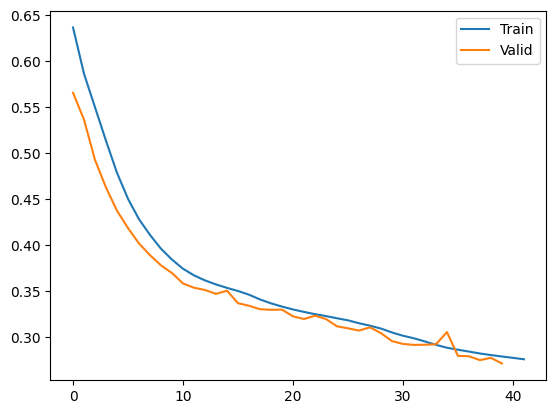

In [42]:
plt.plot(loss_train_hist)
plt.plot(loss_valid_hist)
plt.legend(['Train', 'Valid'])

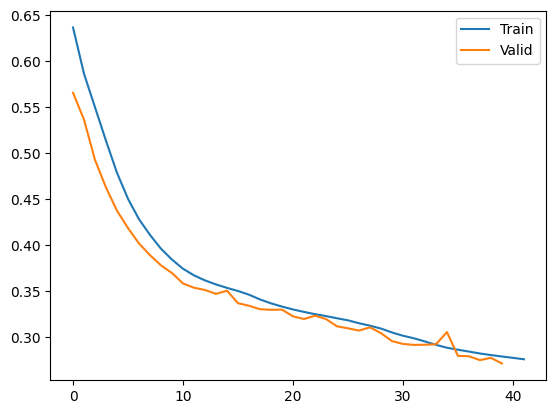

In [43]:
plt.plot(loss_train_hist)
plt.plot(loss_valid_hist)
plt.legend(['Train', 'Valid'])